Чтение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

file_path = "QA-DS-TASK-DATA-FROM-2020-REDUCED-COLUMNS.csv"
df = pd.read_csv(file_path, parse_dates=["Timestamp"])

df.head()

,Timestamp,Close Candle,Ticker Full Name
0,2020-01-01 18:01:00,128.312,10 YEAR TREASURY NOTE FUTURES
1,2020-01-01 18:02:00,128.312,10 YEAR TREASURY NOTE FUTURES
2,2020-01-01 18:03:00,128.312,10 YEAR TREASURY NOTE FUTURES
3,2020-01-01 18:04:00,128.312,10 YEAR TREASURY NOTE FUTURES
4,2020-01-01 18:05:00,128.328,10 YEAR TREASURY NOTE FUTURES


Собираем информацию о типах данных и определяем что бы не было пропущенных значений (NaN) в данных. Результат показывает, что пропуски в таблице не обнаружены.

In [2]:
df.info()

missing_values = df.isnull().sum()
print("\nКоличество пропущенных значений в каждом столбце:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1756857 entries, 0 to 1756856
Data columns (total 3 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Timestamp         datetime64[ns]
 1   Close Candle      float64       
 2   Ticker Full Name  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 40.2+ MB

Количество пропущенных значений в каждом столбце:
 Timestamp           0
Close Candle        0
Ticker Full Name    0
dtype: int64


После группировки данных по Тикеру можно увидеть что количество записей для каждого отличается, следовательно, надо разобраться глубже с причиной отличий. Что могут быть пропуски, дублирования и т.д., что не позволит вычислить лаговость.

In [3]:
grouped_counts = df.groupby("Ticker Full Name")["Timestamp"].count()

print(grouped_counts)

Ticker Full Name
10 YEAR TREASURY NOTE FUTURES    518515
E-MINI S&P 500 FUTURES           672899
FTSE CHINA A50 INDEX FUTURES     565443
Name: Timestamp, dtype: int64


Вычислим минимальные и максимальные даты/время для каждого из Тикеров. Видно, что даты совпадают, а время начала для FTSE CHINA A50 INDEX FUTURES отличается от других двух тикеров, как и время окончания. Но эта разница не может давать такой большой разлет между количеством. Необходимы дальнейшие исследования датасета.

In [7]:
ticker_ranges = df.groupby("Ticker Full Name")["Timestamp"].agg(["min", "max"])

print(ticker_ranges)

                                              min                 max
Ticker Full Name                                                     
10 YEAR TREASURY NOTE FUTURES 2020-01-01 18:01:00 2021-11-30 23:46:00
E-MINI S&P 500 FUTURES        2020-01-01 18:01:00 2021-11-30 23:59:00
FTSE CHINA A50 INDEX FUTURES  2020-01-01 20:01:00 2021-11-30 23:59:00


Для начала сгруппируем данные по тикерам и посмотрим на их распределение по дням недели. Из диаграммы видно, что ни один тикер не имеет данных за субботу.  

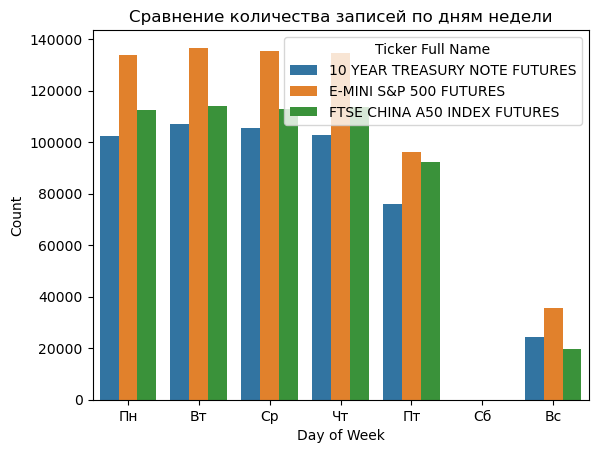

In [10]:
days_mapping = {
    0: "Пн", 1: "Вт", 2: "Ср", 3: "Чт", 4: "Пт", 5: "Сб", 6: "Вс"
}

df["Day of Week"] = df["Timestamp"].dt.dayofweek.map(days_mapping)

count_by_dow = df.groupby(["Ticker Full Name", "Day of Week"]).size().reset_index(name="Count")

ordered_days = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]

count_by_dow["Day of Week"] = pd.Categorical(count_by_dow["Day of Week"], categories=ordered_days, ordered=True)
count_by_dow = count_by_dow.sort_values(["Ticker Full Name", "Day of Week"])

sns.barplot(x="Day of Week", y="Count", hue="Ticker Full Name", data=count_by_dow)
plt.title("Сравнение количества записей по дням недели")
plt.show()

Для того, что бы понять почему так сильно отличаются данные и возможно ли начинать поиск лагов, необходимо сделать разбивку по часам для трех тикеров. 
После этого становится понятно, что для FTSE CHINA A50 INDEX FUTURES и 
10 YEAR TREASURY NOTE FUTURES, E-MINI S&P 500 FUTURES отличаются торговые часы. Так например видно, что для FTSE CHINA A50 INDEX FUTURES отсутствуют данные в период 18-19 часов.

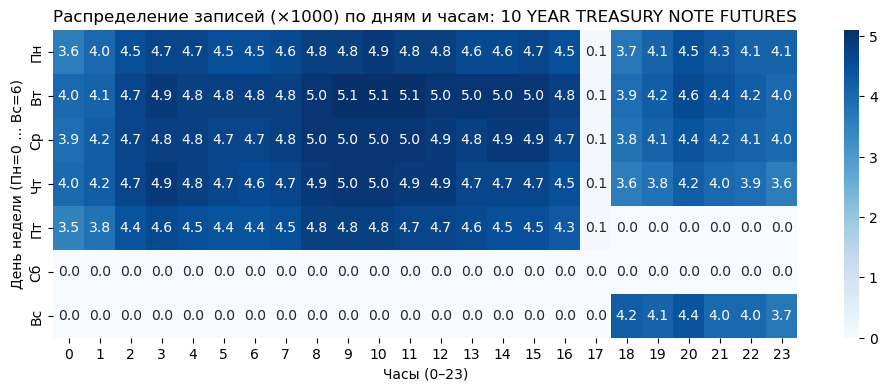

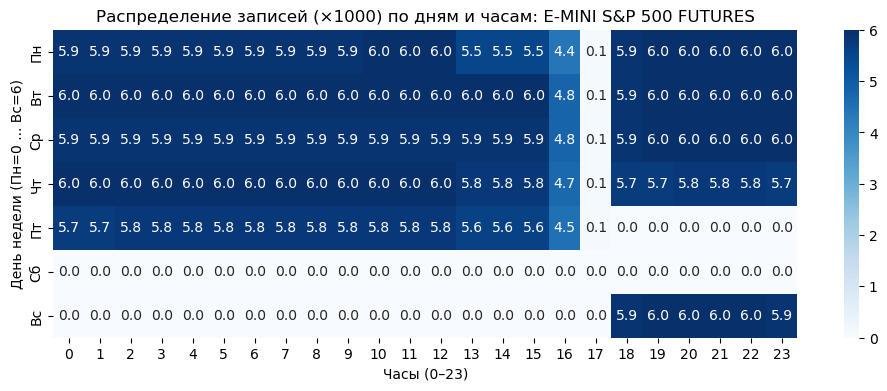

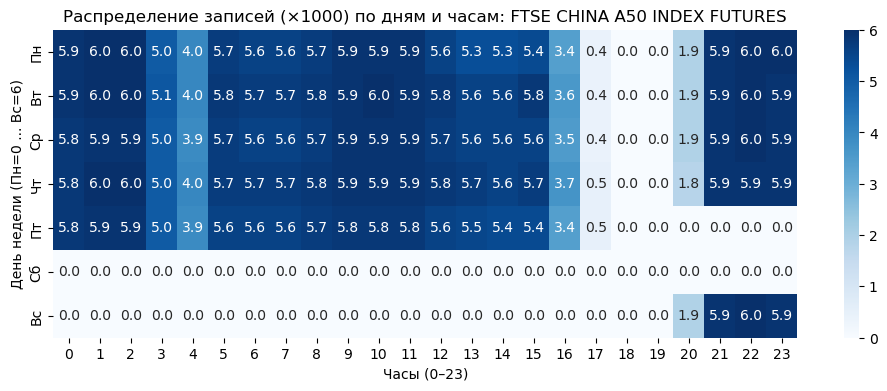

In [14]:
df["Day of Week"] = pd.Categorical(df["Day of Week"], 
                                   categories=ordered_days, 
                                   ordered=True)

df["Hour"] = df["Timestamp"].dt.hour
df["Minute"] = df["Timestamp"].dt.minute

count_by_day_hour = (
    df.groupby(["Ticker Full Name", "Day of Week", "Hour"], observed=False)
      .size()
      .reset_index(name="Count")
)

tickers = count_by_day_hour["Ticker Full Name"].unique()

for ticker in tickers:
    subset = count_by_day_hour[count_by_day_hour["Ticker Full Name"] == ticker]
    
    pivot_data = subset.pivot(index="Day of Week", columns="Hour", values="Count")
    
    pivot_data = pivot_data.fillna(0).astype(float)
    
    pivot_data_thousands = (pivot_data / 1000).round(1)
    
    plt.figure(figsize=(12, 4))
    sns.heatmap(
        pivot_data_thousands, 
        annot=True,
        fmt=".1f",     
        cmap="Blues"
    )
    
    plt.title(f"Распределение записей (×1000) по дням и часам: {ticker}")
    plt.xlabel("Часы (0–23)")
    plt.ylabel("День недели (Пн=0 ... Вс=6)")
    plt.show()


Что бы лучше понять распределение данных в датасете, отобразим графически все минутные данные для трех тикеров. Становиться понятно, что пропуски данных существуют и для определения лагов, надо будет в дальнейшем заполнить их. А также выровнять торговые сессии, то есть лучше когда данные начинаются и заканчиваются  в одинаковые временные промежутки.

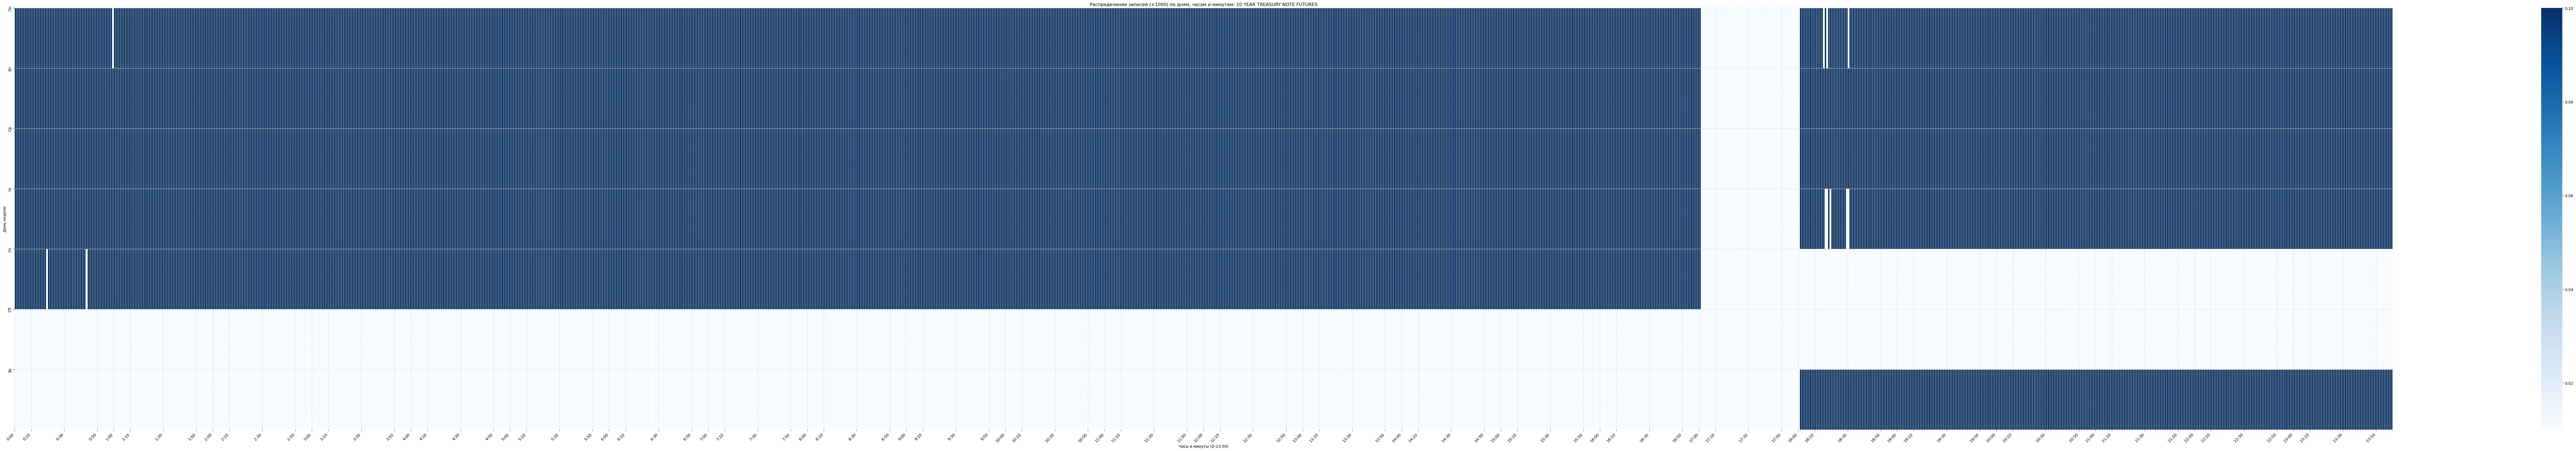

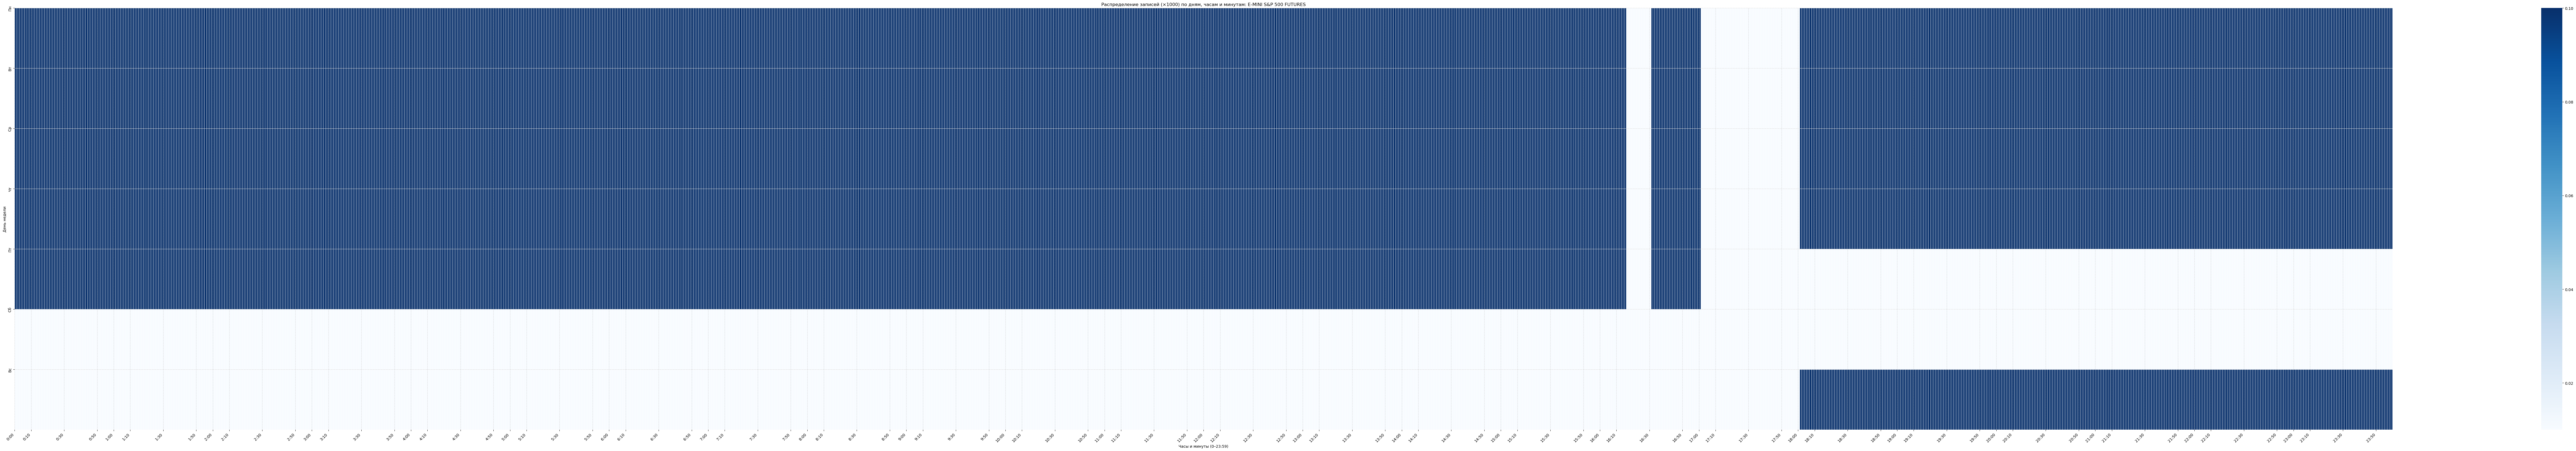

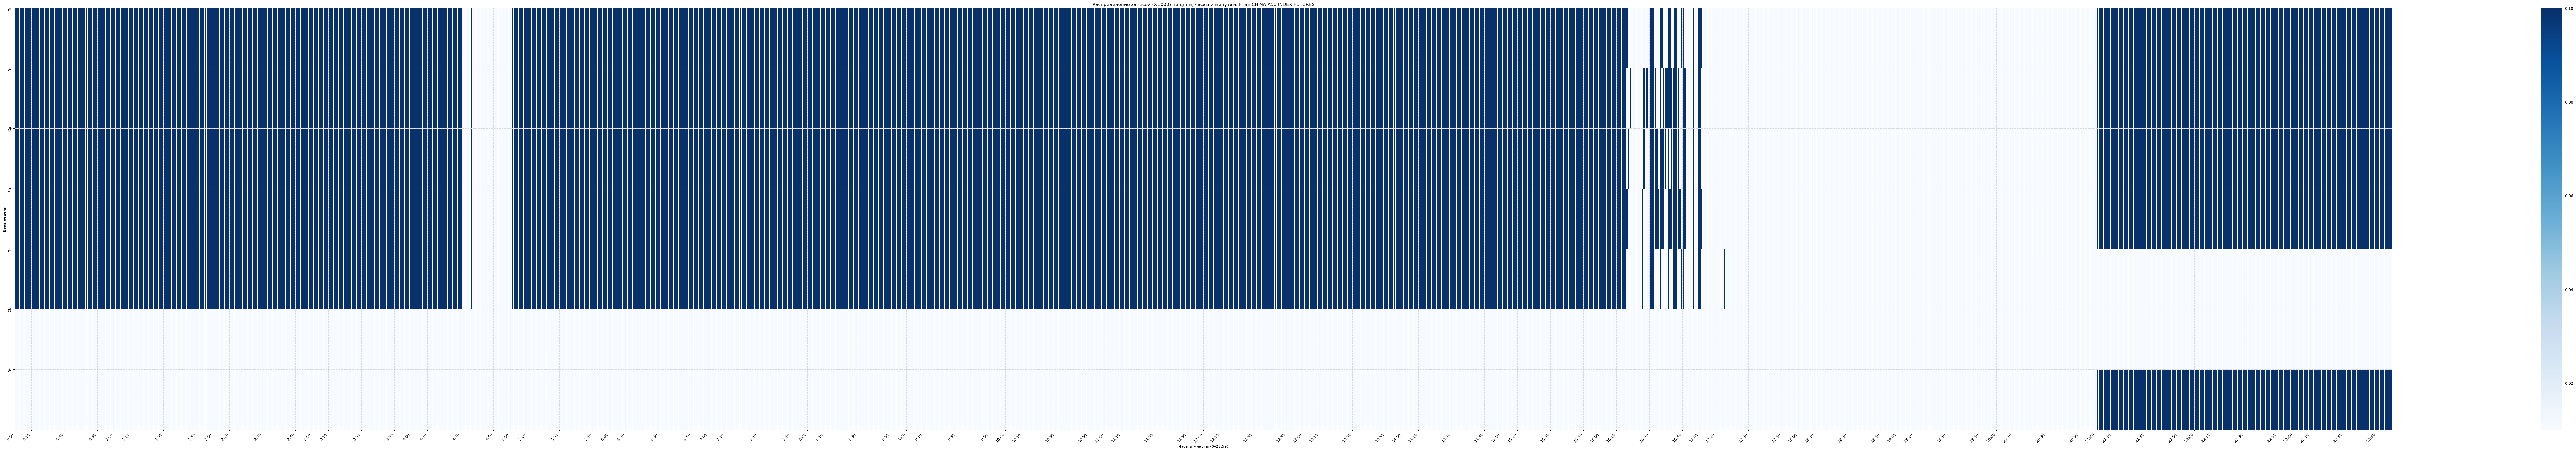

In [17]:
df["Day of Week"] = pd.Categorical(df["Day of Week"], categories=ordered_days, ordered=True)

count_by_day_hour_minute = (
    df.groupby(["Ticker Full Name", "Day of Week", "Hour", "Minute"], observed=False)
      .size()
      .reset_index(name="Count")
)

tickers = count_by_day_hour_minute["Ticker Full Name"].unique()

for ticker in tickers:
    subset = count_by_day_hour_minute[count_by_day_hour_minute["Ticker Full Name"] == ticker]
    
    pivot_data = subset.pivot(index="Day of Week", columns=["Hour", "Minute"], values="Count")
    
    pivot_data = pivot_data.fillna(0).astype(float)
    pivot_data_thousands = (pivot_data / 1000).round(1)

    plt.figure(figsize=(140, 20))
    ax = sns.heatmap(
        pivot_data_thousands, 
        annot=False,  
        cmap="Blues",
        linewidths=0.5,  
        vmin=0.01, vmax=pivot_data_thousands.max().max()  
    )
    
    selected_ticks = [i for i, (h, m) in enumerate(pivot_data.columns) if m in [0, 10, 30, 50]]
    ax.set_xticks(selected_ticks)
    ax.set_xticklabels(
        [f"{h}:{m:02d}" for h, m in pivot_data.columns[selected_ticks]], 
        rotation=45, ha="right"
    )

    ax.set_yticks(np.arange(len(ordered_days)))
    ax.set_yticklabels(ordered_days)

    plt.title(f"Распределение записей (×1000) по дням, часам и минутам: {ticker}")
    plt.xlabel("Часы и минуты (0–23:59)")
    plt.ylabel("День недели")
    plt.grid(True, linestyle="--", alpha=0.5)  

    plt.show()

Вычислим процент пропущенных данных для каждого тикера и время торговых сессий на основании датасета.

In [20]:
trading_hours = {}

MIN_TRADE_DURATION = 30  
missing_data_percentage = {}  

for ticker in count_by_day_hour_minute["Ticker Full Name"].unique():
    subset = count_by_day_hour_minute[count_by_day_hour_minute["Ticker Full Name"] == ticker]

    pivot_data = subset.pivot(index="Day of Week", columns=["Hour", "Minute"], values="Count")

    pivot_data = pivot_data.fillna(0).astype(float)

    trading_schedule = {}
    total_trading_minutes = 0
    available_minutes = 0

    for day in pivot_data.index:  
        active_minutes = pivot_data.loc[day] > 0 
        time_ranges = []
        start = None

        for time, is_active in active_minutes.items():
            if is_active:
                if start is None:
                    start = time  
            else:
                if start is not None:
                    if (time[0] * 60 + time[1]) - (start[0] * 60 + start[1]) >= MIN_TRADE_DURATION:
                        time_ranges.append((start, time))  
                    start = None

        if start is not None:  
            time_ranges.append((start, (23, 59)))

        time_ranges = [
            (s, e) for s, e in time_ranges
            if (e[0] * 60 + e[1]) - (s[0] * 60 + s[1]) >= MIN_TRADE_DURATION
        ]

        for start, end in time_ranges:
            start_min = start[0] * 60 + start[1]
            end_min = end[0] * 60 + end[1]
            total_trading_minutes += (end_min - start_min + 1)  

        available_minutes += active_minutes.sum()

        trading_schedule[day] = time_ranges if time_ranges else None

    trading_hours[ticker] = trading_schedule

    if total_trading_minutes > 0:
        missing_percentage = 100 * (1 - available_minutes / total_trading_minutes)
    else:
        missing_percentage = 100  

    missing_data_percentage[ticker] = round(missing_percentage, 2)

for ticker, schedule in trading_hours.items():
    print(f"\n {ticker}")
    for day, ranges in schedule.items():
        if ranges:
            print(f"  {day}: " + ", ".join([f"({start[0]}:{start[1]:02d} - {end[0]}:{end[1]:02d})" for start, end in ranges]))
        else:
            print(f"  {day}:  Нет торгов")

print("\n Процент пропусков данных внутри торговых часов:")
for ticker, percentage in missing_data_percentage.items():
    print(f"{ticker}: {percentage}% пропущенных данных")


 10 YEAR TREASURY NOTE FUTURES
  Пн: (0:00 - 17:01), (18:01 - 23:59)
  Вт: (0:00 - 17:01), (18:01 - 23:59)
  Ср: (0:00 - 17:01), (18:01 - 23:59)
  Чт: (0:00 - 17:01), (18:01 - 23:59)
  Пт: (0:00 - 17:01)
  Сб:  Нет торгов
  Вс: (18:01 - 23:59)

 E-MINI S&P 500 FUTURES
  Пн: (0:00 - 17:01), (18:01 - 23:59)
  Вт: (0:00 - 17:01), (18:01 - 23:59)
  Ср: (0:00 - 17:01), (18:01 - 23:59)
  Чт: (0:00 - 17:01), (18:01 - 23:59)
  Пт: (0:00 - 17:01)
  Сб:  Нет торгов
  Вс: (18:01 - 23:59)

 FTSE CHINA A50 INDEX FUTURES
  Пн: (0:00 - 17:17), (20:01 - 23:59)
  Вт: (0:00 - 17:16), (20:01 - 23:59)
  Ср: (0:00 - 17:16), (20:01 - 23:59)
  Чт: (0:00 - 17:17), (20:01 - 23:59)
  Пт: (0:00 - 17:16)
  Сб:  Нет торгов
  Вс: (20:01 - 23:59)

 Процент пропусков данных внутри торговых часов:
10 YEAR TREASURY NOTE FUTURES: 0.07% пропущенных данных
E-MINI S&P 500 FUTURES: 0.06% пропущенных данных
FTSE CHINA A50 INDEX FUTURES: 0.08% пропущенных данных


После того как вычислили время торговых сессий для каждого тикера, надо сделать датасет df_aligned с которым будем работать. Данные надо выровнять, а именно:
 Пн: (0:00 - 17:01), (20:01 - 23:59)
  Вт: (0:00 - 17:01), (20:01 - 23:59)
  Ср: (0:00 - 17:01), (20:01 - 23:59)
  Чт: (0:00 - 17:01), (20:01 - 23:59)
  Пт: (0:00 - 17:01)
  Вс: (20:01 - 23:59)
Все три тикера должны быть в этих пределах для поиска лага. 

In [24]:
trading_hours_default = {
    'Пн': [((0, 0), (17, 1)), ((20, 1), (23, 59))],
    'Вт': [((0, 0), (17, 1)), ((20, 1), (23, 59))],
    'Ср': [((0, 0), (17, 1)), ((20, 1), (23, 59))],
    'Чт': [((0, 0), (17, 1)), ((20, 1), (23, 59))],
    'Пт': [((0, 0), (17, 1))],
    'Сб': None,
    'Вс': [((20, 1), (23, 59))]
}

df_original = df.copy()
df_work = df_original.copy()

df_work.index = pd.to_datetime(df_work.index)
if 'Timestamp' not in df_work.columns:
    df_work['Timestamp'] = df_work.index
df_work['Timestamp'] = pd.to_datetime(df_work['Timestamp'])

min_date = pd.Timestamp('2020-01-02 00:00:00')
max_date = df_work['Timestamp'].max().floor('D')

df_list = []

for ticker in df_work['Ticker Full Name'].unique():
    df_ticker = df_work[df_work['Ticker Full Name'] == ticker].copy()
    df_ticker = df_ticker.set_index('Timestamp').sort_index()
    
    allowed_timestamps = []
    current_day = min_date
    while current_day <= max_date:
        day_abbr = days_mapping[current_day.weekday()]
        intervals = trading_hours_default.get(day_abbr, None)
        if intervals is not None:
            for interval in intervals:
                start_time = current_day + pd.Timedelta(hours=interval[0][0], minutes=interval[0][1])
                end_time   = current_day + pd.Timedelta(hours=interval[1][0], minutes=interval[1][1])
                ts_range = pd.date_range(start=start_time, end=end_time, freq='min')
                allowed_timestamps.append(ts_range)
        current_day += pd.Timedelta(days=1)
    
    if allowed_timestamps:
        allowed_timestamps = pd.concat([pd.Series(x) for x in allowed_timestamps]).drop_duplicates().sort_values()
    else:
        allowed_timestamps = pd.DatetimeIndex([])
    
    df_ticker_aligned = df_ticker.reindex(allowed_timestamps)
    
    df_ticker_aligned = df_ticker_aligned.ffill().bfill()
    
    df_ticker_aligned = df_ticker_aligned.reset_index().rename(columns={'index': 'Timestamp'})
    
    df_ticker_aligned['Ticker Full Name'] = ticker
    
    df_list.append(df_ticker_aligned)

df_aligned = pd.concat(df_list, ignore_index=True)

df_aligned = df_aligned.dropna(subset=['Close Candle'])

Проверка типа данных и пропусков

In [26]:
df_aligned.info()
missing_values = df_aligned.isnull().sum()
print("\nКоличество пропущенных значений в каждом столбце:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887717 entries, 0 to 1887716
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Timestamp         datetime64[ns]
 1   Close Candle      float64       
 2   Ticker Full Name  object        
 3   Day of Week       category      
 4   Hour              float64       
 5   Minute            float64       
dtypes: category(1), datetime64[ns](1), float64(3), object(1)
memory usage: 73.8+ MB

Количество пропущенных значений в каждом столбце:
 Timestamp           0
Close Candle        0
Ticker Full Name    0
Day of Week         0
Hour                0
Minute              0
dtype: int64


Отобразим графически данные, что бы убедиться, что нет разрывов.

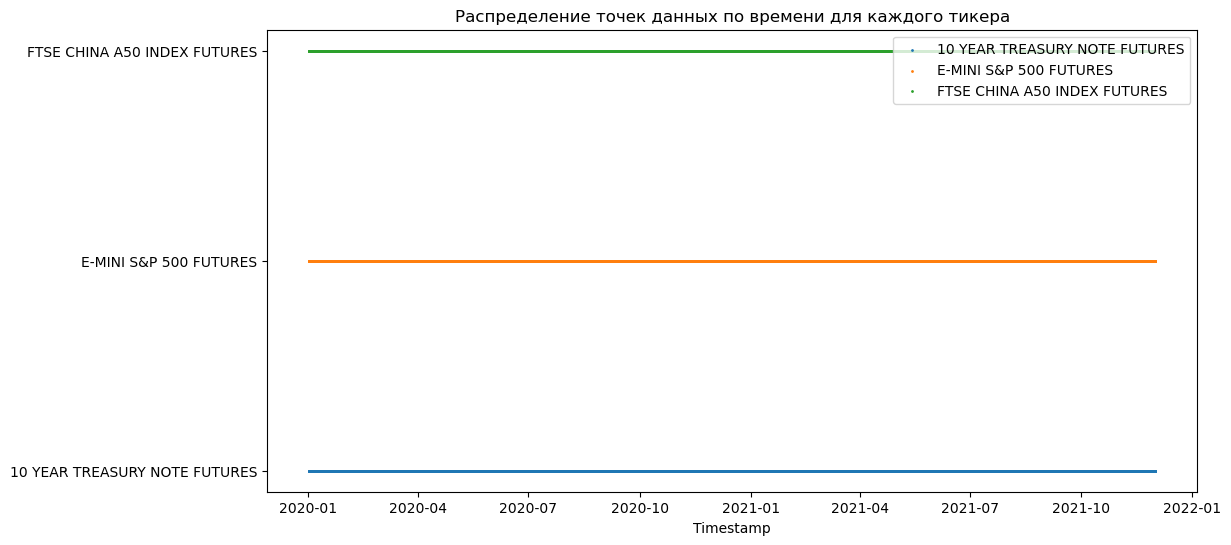

In [30]:
plt.figure(figsize=(12, 6))
for i, ticker in enumerate(tickers):
    df_temp = df_aligned[df_aligned['Ticker Full Name'] == ticker]
    plt.scatter(df_temp['Timestamp'], [i]*len(df_temp), s=1, label=ticker)

plt.yticks(range(len(tickers)), tickers)
plt.xlabel('Timestamp')
plt.title('Распределение точек данных по времени для каждого тикера')
plt.legend()
plt.show()



Отобразим графически все три тикера, для понимания как выглядят графики. Так как шкалы ЦЕНА имеют разные значения, отображение графиков сделаем пропорциональным.

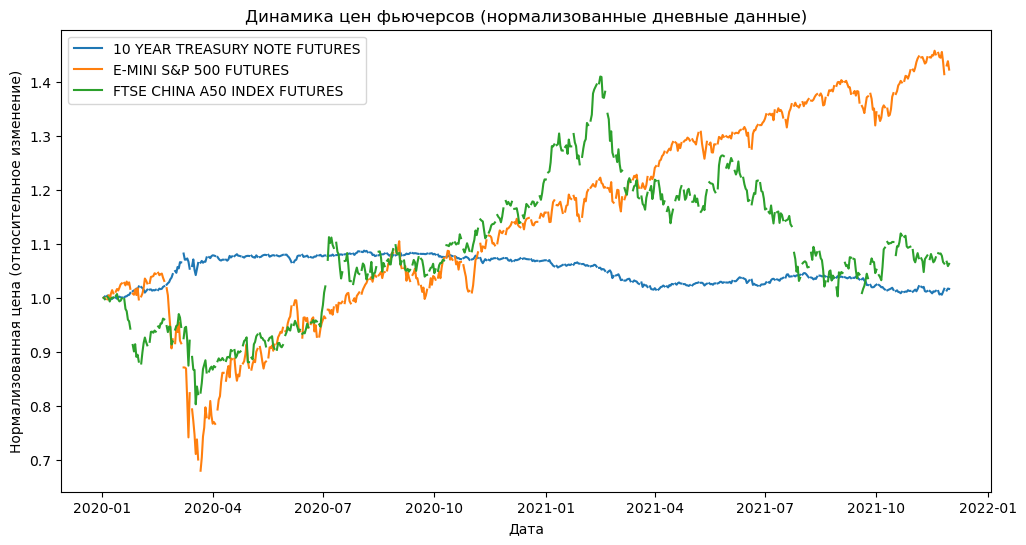

In [33]:
df_aligned['Timestamp'] = pd.to_datetime(df_aligned['Timestamp'])

df_aligned = df_aligned.set_index("Timestamp")

df_daily = df_aligned.groupby("Ticker Full Name").resample("1D")["Close Candle"].last().reset_index()

df_pivot = df_daily.pivot(index="Timestamp", columns="Ticker Full Name", values="Close Candle")

df_pivot.sort_index(inplace=True)

df_norm = df_pivot / df_pivot.iloc[0]

plt.figure(figsize=(12, 6))
for col in df_norm.columns:
    plt.plot(df_norm.index, df_norm[col], label=col)

plt.title("Динамика цен фьючерсов (нормализованные дневные данные)")
plt.xlabel("Дата")
plt.ylabel("Нормализованная цена (относительное изменение)")
plt.legend()
plt.show()


Построим корреляционные матрицы с разными таймфреймами для определения, какой таймфрейм может лучше подойти для определения лаговой зависимости. 
Из набора матриц видно, что наиболее актуальным является таймфрейм 1 день и наибольшая корреляция присутствует между FTSE CHINA A50 INDEX FUTURES и E-MINI S&P 500 FUTURES

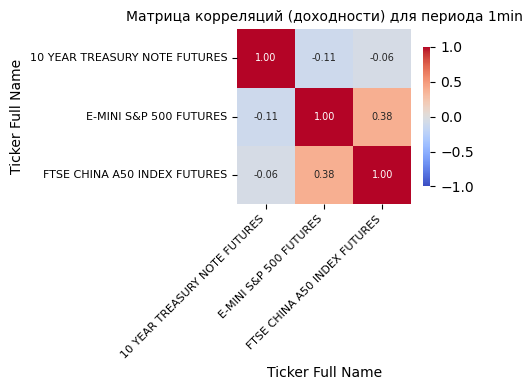

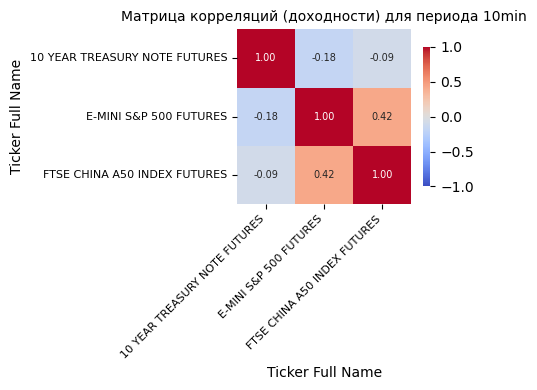

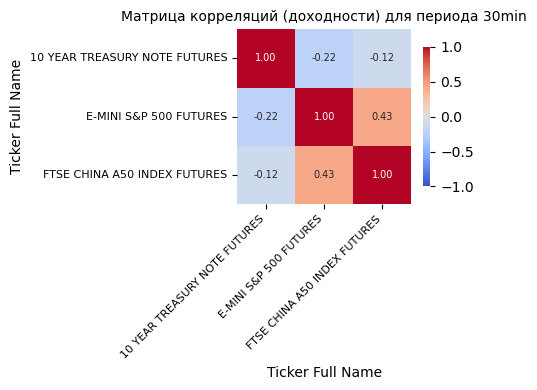

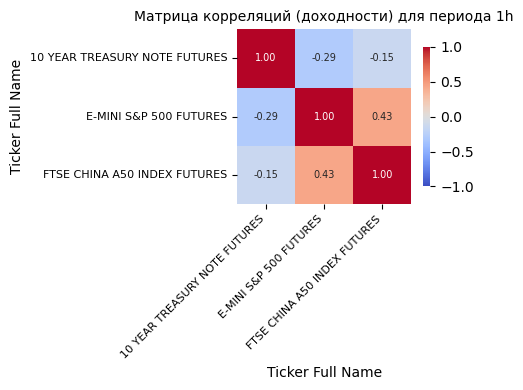

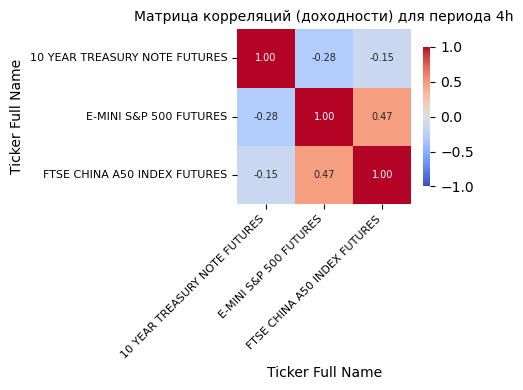

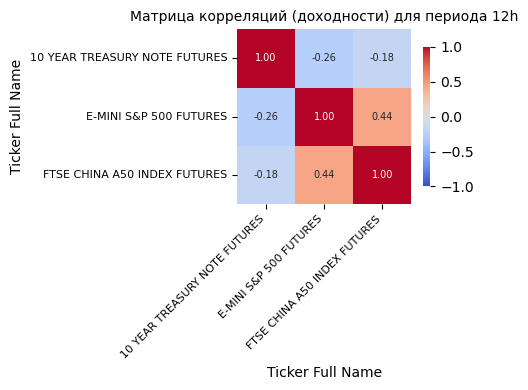

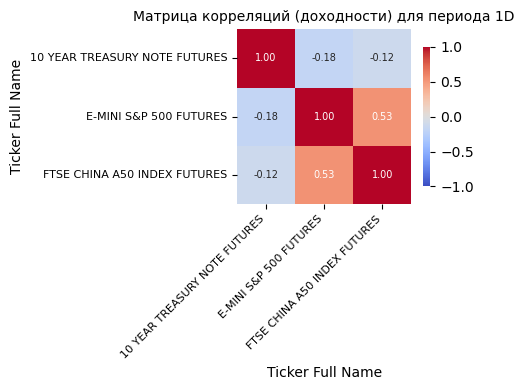

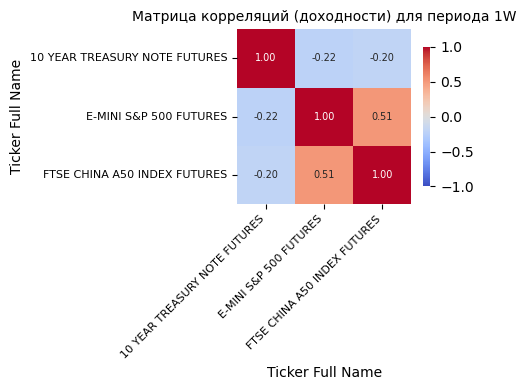

In [35]:
periods = ['1min', '10min', '30min', '1h', '4h', '12h', '1D', '1W']

for period in periods:
    df_resampled = df_aligned.groupby("Ticker Full Name") \
                              .resample(period)["Close Candle"] \
                              .last() \
                              .reset_index()

    df_pivot_period = df_resampled.pivot(index="Timestamp", columns="Ticker Full Name", values="Close Candle")
    df_pivot_period.sort_index(inplace=True)

    df_returns = np.log(df_pivot_period / df_pivot_period.shift(1))
    df_returns.dropna(inplace=True)

    corr_matrix = df_returns.corr()

    plt.figure(figsize=(5, 4), dpi=100)  
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        annot_kws={"size": 7},   
        square=True,            
        cbar_kws={"shrink": 0.8} 
    )
    plt.xticks(fontsize=8, rotation=45, ha='right')  
    plt.yticks(fontsize=8, rotation=0)               
    plt.title(f"Матрица корреляций (доходности) для периода {period}", fontsize=10)
    plt.tight_layout()  
    plt.show()

Вычислим взаимосвязь между доходностями тикеров для разных таймфремов. Как результат видим, что особо выраженной связи не наблюдается. Наиболее лучше она выражается на дневном интервале для 
FTSE CHINA A50 INDEX FUTURES и E-MINI S&P 500 FUTURES

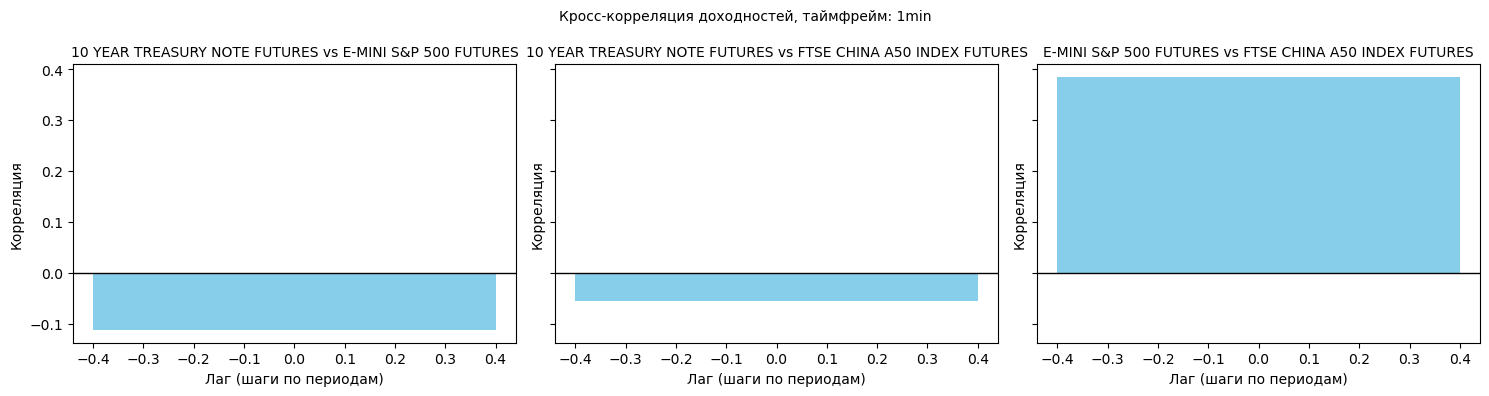

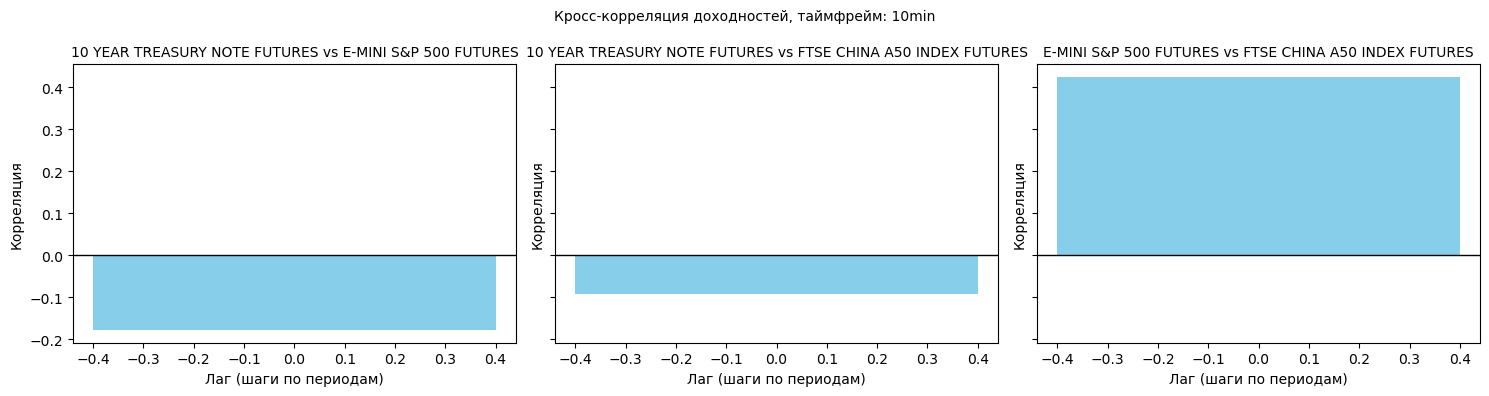

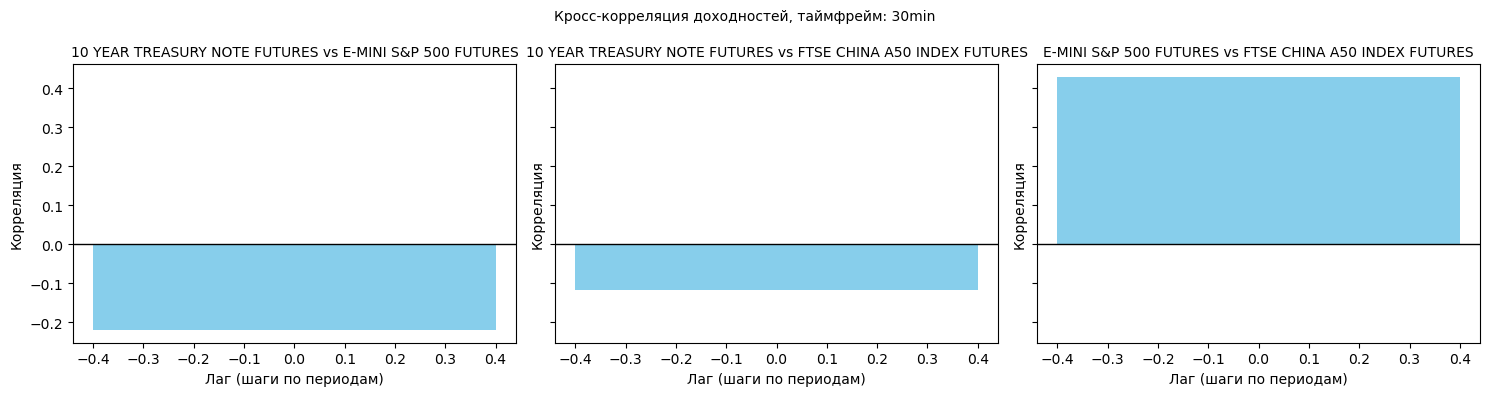

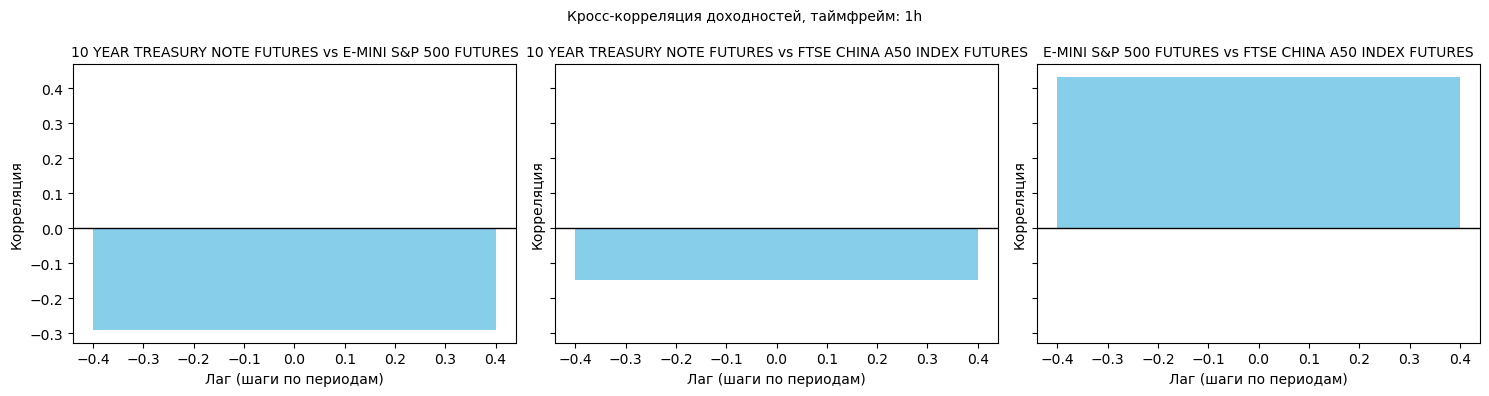

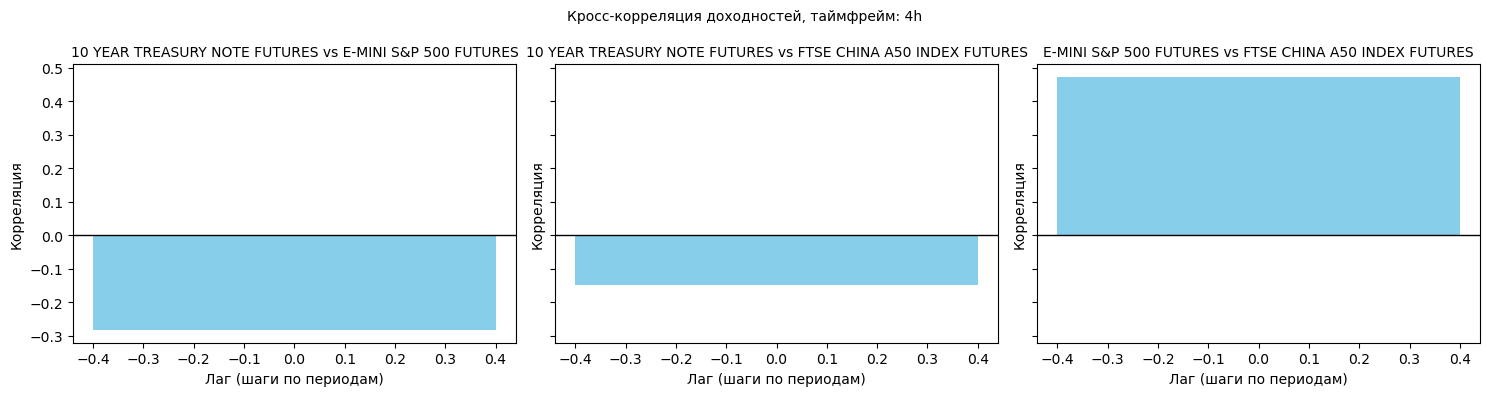

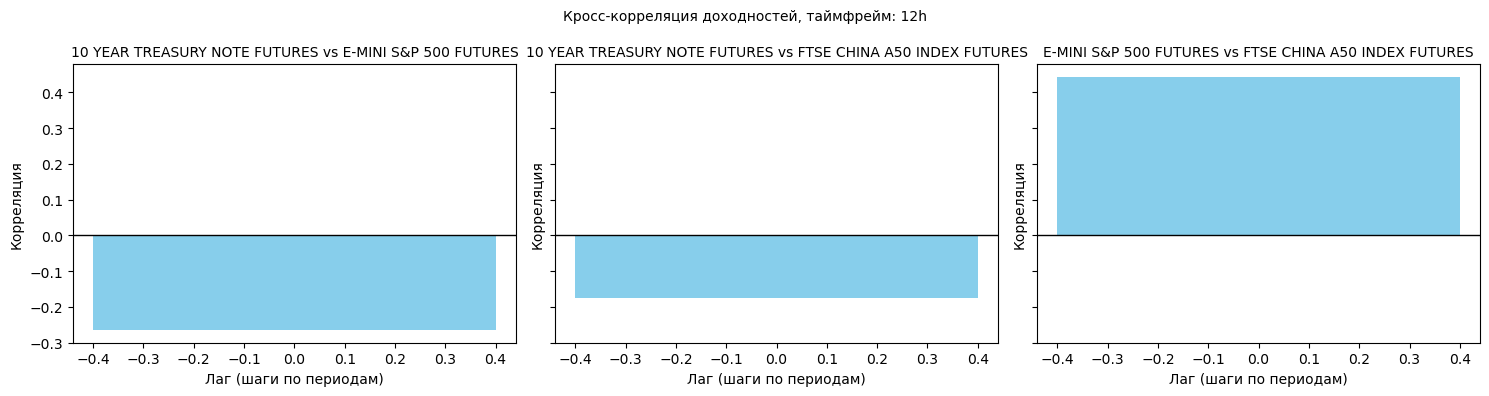

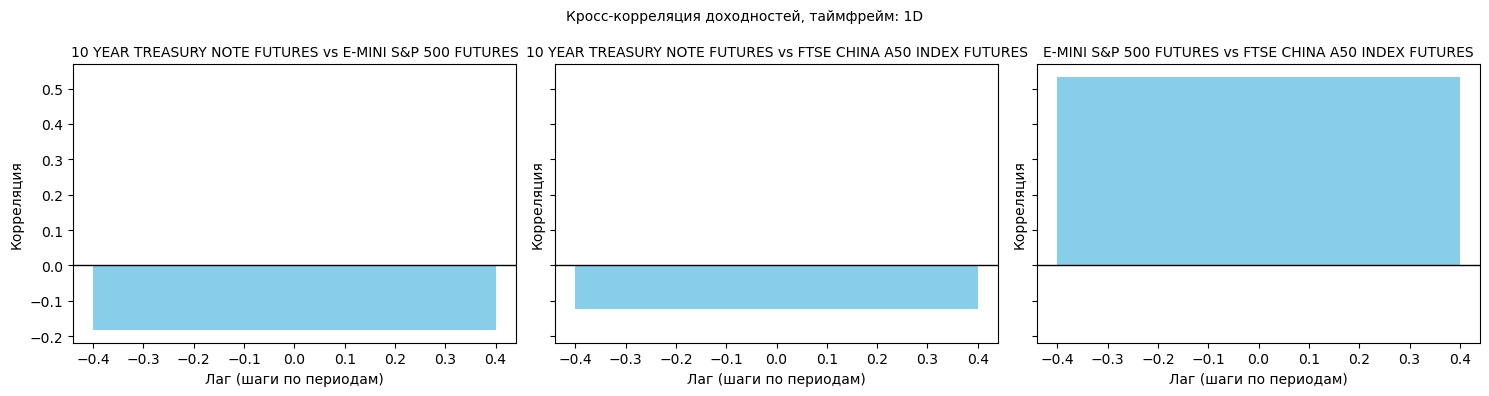

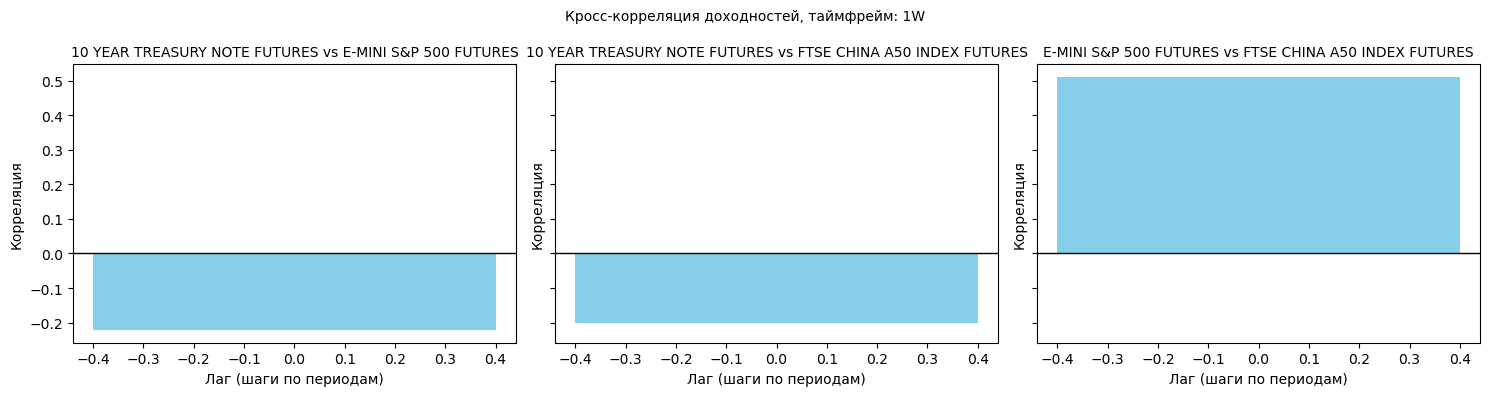

In [38]:
import itertools
from statsmodels.tsa.stattools import ccf

def crosscorr_series(x, y, lag_range=10):
    x = x.dropna()
    y = y.dropna()

    common_index = x.index.intersection(y.index)
    x = x.loc[common_index]
    y = y.loc[common_index]

    lags = list(range(-lag_range, lag_range + 1))
    ccs = []
    for lag in lags:
        if lag < 0:
            shifted = y.shift(abs(lag))
            aligned_x, aligned_y = x.align(shifted, join="inner")
            c = np.corrcoef(aligned_x, aligned_y)[0, 1]
        else:
            shifted = x.shift(lag)
            aligned_x, aligned_y = shifted.align(y, join="inner")
            c = np.corrcoef(aligned_x, aligned_y)[0, 1]
        ccs.append(c)
    return lags, ccs

for period in periods:
    df_resampled = (
        df_aligned
        .groupby("Ticker Full Name")
        .resample(period)["Close Candle"]
        .last()
        .reset_index()
    )

    df_pivot = df_resampled.pivot(
        index="Timestamp",
        columns="Ticker Full Name",
        values="Close Candle"
    )

    df_pivot.sort_index(inplace=True)

    df_returns = np.log(df_pivot / df_pivot.shift(1))
    df_returns.dropna(inplace=True)

    pairs = list(itertools.combinations(tickers, 2))
    num_pairs = len(pairs)

    fig, axs = plt.subplots(1, num_pairs, figsize=(5 * num_pairs, 4), sharey=True)
    if num_pairs == 1:
        axs = [axs]

    for ax, (inst1, inst2) in zip(axs, pairs):
        if inst1 not in df_returns.columns or inst2 not in df_returns.columns:
            ax.set_title(f"Нет данных для пары {inst1}, {inst2}")
            continue

        x_series = df_returns[inst1]
        y_series = df_returns[inst2]
        lags, ccs = crosscorr_series(x_series, y_series, lag_range=10)

        ax.bar(lags, ccs, width=0.8, color="skyblue")
        ax.axhline(0, color="k", linewidth=1)
        ax.set_title(f"{inst1} vs {inst2}", fontsize=10)
        ax.set_xlabel("Лаг (шаги по периодам)")
        ax.set_ylabel("Корреляция")

    fig.suptitle(
        f"Кросс-корреляция доходностей, таймфрейм: {period}",
        fontsize=10
    )
    plt.tight_layout()
    plt.show()

Проверяем движутся ли активы вместе в долгосрочной перспективе или ведут себя независимо. Для этого берем логарифмы цен и анализируем их связь. Видим что  Rank = 0 (коинтеграции нет), во всех результатах активы движутся независимо. То есть, на 1-минутном таймфрейме Trace Statistic для Rank = 0 равно 21.96, а критическое значение на 95% уровне — 29.79, это значит, что связь не подтверждается. Rank = 1, связи между двумя активами тоже не найдена. Rank = 2, связь ещё сильнее, но таких случаев в тесте тоже нет. На всех таймфреймах, включая 10-минутный, 30-минутный, 1-часовой и дневной, статистики не превышают критические пороги, это говорит о том, что устойчивой связи между активами нет. Но это не доказывает отсутствие лага в некоторых промежутках, вполне возможно в каком то месяце она и есть, поэтому продолжаем исследовать дальше.

In [41]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen


for period in periods:
    df_resampled = (
        df_aligned
        .groupby("Ticker Full Name")
        .resample(period)["Close Candle"]
        .last()
        .reset_index()
    )
    
    df_pivot = df_resampled.pivot(index="Timestamp", columns="Ticker Full Name", values="Close Candle")
    df_pivot.sort_index(inplace=True)
    
    df_pivot = df_pivot.dropna()
    
    if df_pivot.empty:
        print(f"Для таймфрейма {period} недостаточно данных.")
        continue
    
    df_log = np.log(df_pivot)
    
    johansen_result = coint_johansen(df_log, det_order=0, k_ar_diff=1)
    
    print(f"=== Johansen Test для таймфрейма: {period} ===")
    
    print("Trace Statistic:")
    for i, stat in enumerate(johansen_result.lr1):
        crit_90, crit_95, crit_99 = johansen_result.cvt[i]
        print(f"Rank = {i}: Statistic = {stat:.4f},  Crit(90%) = {crit_90:.4f},  Crit(95%) = {crit_95:.4f},  Crit(99%) = {crit_99:.4f}")
    
    print("\nMax Eigenvalue Statistic:")
    for i, stat in enumerate(johansen_result.lr2):
        crit_90, crit_95, crit_99 = johansen_result.cvm[i]
        print(f"Rank = {i}: Statistic = {stat:.4f},  Crit(90%) = {crit_90:.4f},  Crit(95%) = {crit_95:.4f},  Crit(99%) = {crit_99:.4f}")
    
    print("\n" + "-"*60 + "\n")


=== Johansen Test для таймфрейма: 1min ===
Trace Statistic:
Rank = 0: Statistic = 21.9611,  Crit(90%) = 27.0669,  Crit(95%) = 29.7961,  Crit(99%) = 35.4628
Rank = 1: Statistic = 6.7440,  Crit(90%) = 13.4294,  Crit(95%) = 15.4943,  Crit(99%) = 19.9349
Rank = 2: Statistic = 1.1142,  Crit(90%) = 2.7055,  Crit(95%) = 3.8415,  Crit(99%) = 6.6349

Max Eigenvalue Statistic:
Rank = 0: Statistic = 15.2172,  Crit(90%) = 18.8928,  Crit(95%) = 21.1314,  Crit(99%) = 25.8650
Rank = 1: Statistic = 5.6298,  Crit(90%) = 12.2971,  Crit(95%) = 14.2639,  Crit(99%) = 18.5200
Rank = 2: Statistic = 1.1142,  Crit(90%) = 2.7055,  Crit(95%) = 3.8415,  Crit(99%) = 6.6349

------------------------------------------------------------

=== Johansen Test для таймфрейма: 10min ===
Trace Statistic:
Rank = 0: Statistic = 21.2195,  Crit(90%) = 27.0669,  Crit(95%) = 29.7961,  Crit(99%) = 35.4628
Rank = 1: Statistic = 6.8643,  Crit(90%) = 13.4294,  Crit(95%) = 15.4943,  Crit(99%) = 19.9349
Rank = 2: Statistic = 0.9852,  C

Проверял только для дневного и недельного таймфрейма, очень долго прогоняются тесты.
Код строит VAR-модель, чтобы проверить, как прошлые значения активов влияют на их будущие движения, и проводит тест Гранжера, чтобы определить, есть ли причинно-следственные связи между ними. Данные агрегируются по разным таймфреймам (1 день, 1 неделя), затем вычисляются логарифмические доходности и тестируется лаговая зависимость.

Выводы:

S&P 500 и 10-летние облигации оказывают взаимное влияние (p-value < 0.05).
FTSE China A50 не имеет значимой связи с двумя другими активами, что говорит о слабой зависимости.
Оптимальное число лагов чаще всего 1–4, что подтверждает короткую лаговую зависимость. 
VAR показывает, что S&P 500 может частично предсказывать движения облигаций.

In [43]:
from statsmodels.tsa.api import VAR
import itertools
import matplotlib.pyplot as plt

if "Timestamp" not in df_aligned.columns:
    df_aligned = df_aligned.reset_index()

df_aligned.sort_index(inplace=True)


# periods = ['1min', '10min', '30min', '1h', '4h', '12h', '1D', '1W'] №очень долго выполняется, сделаю только для двух периодов
periods = ['1D', '1W']

for period in periods:
    print(f"\n=== VAR & Granger для периода: {period} ===")
    
    df_resampled = (
        df_aligned
        .groupby("Ticker Full Name")
        .resample(period, on="Timestamp")["Close Candle"]
        .last()
        .reset_index()
    )
    
    df_pivot_period = df_resampled.pivot(
        index="Timestamp",
        columns="Ticker Full Name",
        values="Close Candle"
    )
    df_pivot_period.sort_index(inplace=True)
    
    df_log = np.log(df_pivot_period)
    
    df_diff = df_log.diff().dropna()
    
    model = VAR(df_diff)
    
    results = model.fit(ic='aic')
    print(results.summary())
    
    if results.k_ar == 0:
        print("\nОптимальное число лагов равно 0, переоцениваем модель с 1 лагом для теста Гранжера.")
        results = model.fit(1)
        print(results.summary())
    
    tickers = df_diff.columns.tolist()
    print("\nСписок тикеров:", tickers)
    
    pairs = list(itertools.combinations(tickers, 2))
    
    for tickerX, tickerY in pairs:
        test_forward = results.test_causality(caused=tickerY, causing=[tickerX], kind='f')
        test_reverse = results.test_causality(caused=tickerX, causing=[tickerY], kind='f')
    
        print(f"\n>>> GRANGER-тест: {tickerX} -> {tickerY}")
        print(test_forward.summary())
    
        print(f">>> GRANGER-тест: {tickerY} -> {tickerX}")
        print(test_reverse.summary())



=== VAR & Granger для периода: 1D ===


C:\Users\Denis\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Feb, 2025
Time:                     00:25:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -29.1332
Nobs:                     494.000    HQIC:                  -29.3348
Log likelihood:           5214.00    FPE:                1.59778e-13
AIC:                     -29.4650    Det(Omega_mle):     1.47800e-13
--------------------------------------------------------------------
Results for equation 10 YEAR TREASURY NOTE FUTURES
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                   -0.000067         0.000121           -0.553           0.580
L1.10 YEAR TREASURY NOTE FUTURES        -0.000075         0.

C:\Users\Denis\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Проводим тест Гранжера для E-MINI S&P 500 FUTURES', '10 YEAR TREASURY NOTE FUTURES где вычисляем, что при лагах 2-5 связь становится значимой (p-value = 0.00), это нам показывает, что S&P 500 может предсказывать 10-летние облигации

In [45]:
from statsmodels.tsa.stattools import grangercausalitytests

for lag in range(1, 6):
    print(f"\n>>> Тест Гранжера с {lag} лага(ов) <<<")
    grangercausalitytests(df_diff[['E-MINI S&P 500 FUTURES', '10 YEAR TREASURY NOTE FUTURES']], maxlag=lag, verbose=True)


>>> Тест Гранжера с 1 лага(ов) <<<

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0184  , p=0.8922  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.0190  , p=0.8903  , df=1
likelihood ratio test: chi2=0.0190  , p=0.8903  , df=1
parameter F test:         F=0.0184  , p=0.8922  , df_denom=96, df_num=1

>>> Тест Гранжера с 2 лага(ов) <<<

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0184  , p=0.8922  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.0190  , p=0.8903  , df=1
likelihood ratio test: chi2=0.0190  , p=0.8903  , df=1
parameter F test:         F=0.0184  , p=0.8922  , df_denom=96, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.8273 , p=0.0000  , df_denom=93, df_num=2
ssr based chi2 test:   chi2=31.2490 , p=0.0000  , df=2
likelihood ratio test: chi2=27.1238 , p=0.0000  , df=2
parameter F test:         F=14.8273 , p=0.0000  , df_denom=93, df_num=2

>>> Тест Гранжера с 3 лага(

Пишем торговую стратеги, таймфрейм 1 день, с лагом 2, где прогнозируем 10 YEAR TREASURY NOTE FUTURES, на основе E-MINI S&P 500 FUTURES. И ... получаем убыток. Что говорит, еще раз, что лаговая зависимость есть, но она не постоянна.

 Доходность стратегии (Lag 2, 1D): nan%
 Доходность 'купи и держи' (1D): 46.22%


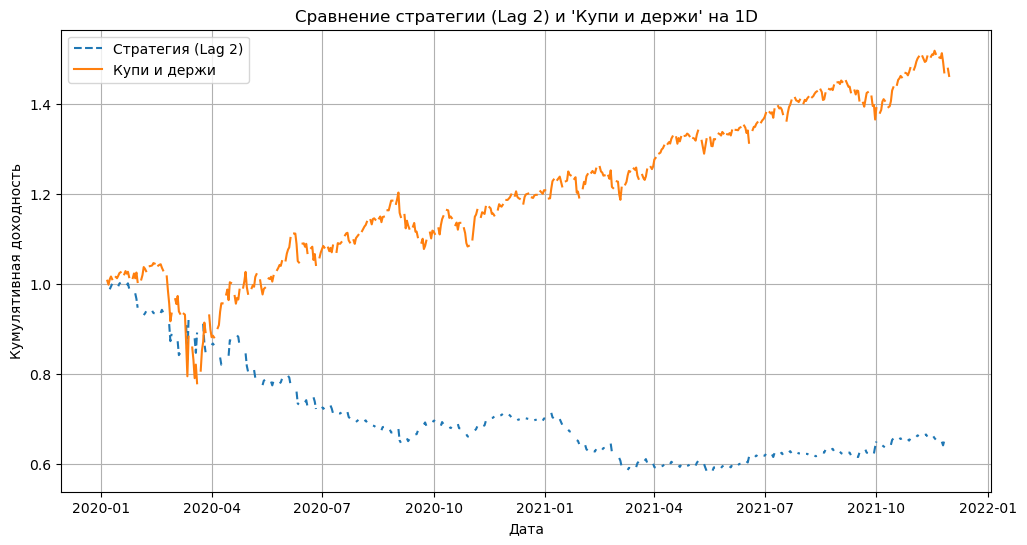

In [47]:
timeframe = "1D"  

df_resampled = (
    df_aligned
    .groupby("Ticker Full Name")
    .resample(timeframe, on="Timestamp")["Close Candle"]
    .last()
    .reset_index()
)


df_pivot_period = df_resampled.pivot(
    index="Timestamp",
    columns="Ticker Full Name",
    values="Close Candle"
)
df_pivot_period.sort_index(inplace=True)


ticker_x = "10 YEAR TREASURY NOTE FUTURES"  
ticker_y = "E-MINI S&P 500 FUTURES"  


df_trading = df_pivot_period[[ticker_x, ticker_y]].copy()
df_trading = np.log(df_trading).diff() 

df_trading["Signal"] = np.sign(df_trading[ticker_x].shift(2))

df_trading["Strategy Returns"] = df_trading["Signal"] * df_trading[ticker_y]

df_trading["Buy & Hold"] = df_trading[ticker_y]

df_trading["Cumulative Strategy"] = df_trading["Strategy Returns"].cumsum().apply(np.exp)
df_trading["Cumulative Buy & Hold"] = df_trading["Buy & Hold"].cumsum().apply(np.exp)

final_strategy = df_trading["Cumulative Strategy"].iloc[-1] - 1
final_buy_hold = df_trading["Cumulative Buy & Hold"].iloc[-1] - 1

print(f" Доходность стратегии (Lag 2, {timeframe}): {final_strategy:.2%}")
print(f" Доходность 'купи и держи' ({timeframe}): {final_buy_hold:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(df_trading.index, df_trading["Cumulative Strategy"], label="Стратегия (Lag 2)", linestyle="--")
plt.plot(df_trading.index, df_trading["Cumulative Buy & Hold"], label="Купи и держи", linestyle="-")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Кумулятивная доходность")
plt.title(f"Сравнение стратегии (Lag 2) и 'Купи и держи' на {timeframe}")
plt.grid()
plt.show()


Теперь проводим тест Гранжера на таймфрейме 1 день, с окнами равными 10 дней. То есть каждые 10 дней проверяем, есть ли зависимость с лагом 2 между E-MINI S&P 500 FUTURES и 10 YEAR TREASURY NOTE FUTURES. Все значения p<0.05 говорят о зависимости (красная линия). То есть мы видим, что лаговая зависимость есть, но только в определенные периоды.

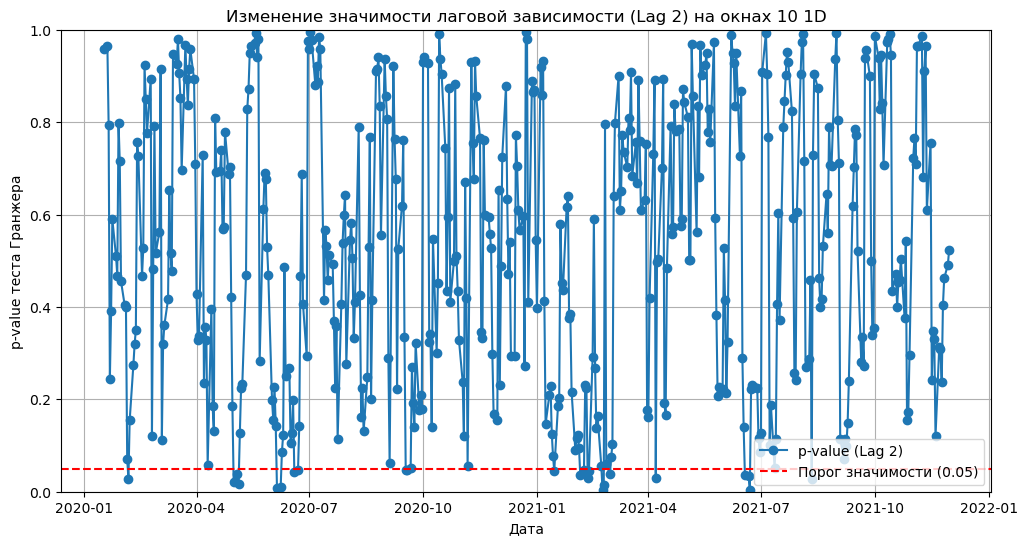

In [49]:

timeframe = "1D"  
window_size = 10  

df_resampled = (
    df_aligned
    .groupby("Ticker Full Name")
    .resample(timeframe, on="Timestamp")["Close Candle"]
    .last()
    .reset_index()
)

df_pivot_period = df_resampled.pivot(
    index="Timestamp",
    columns="Ticker Full Name",
    values="Close Candle"
)
df_pivot_period.sort_index(inplace=True)

ticker_x = "10 YEAR TREASURY NOTE FUTURES"
ticker_y = "E-MINI S&P 500 FUTURES"


df_trading = df_pivot_period[[ticker_x, ticker_y]].copy()
df_trading = np.log(df_trading).diff().dropna()

dates = df_trading.index
rolling_p_values = []

for i in range(len(dates) - window_size):
    start_date = dates[i]
    end_date = dates[i + window_size]

    df_window = df_trading.loc[start_date:end_date]

    try:
        test_result = grangercausalitytests(df_window[[ticker_y, ticker_x]], maxlag=2, verbose=False)
        p_value = test_result[2][0]['ssr_ftest'][1]  
        if p_value < 0 or p_value > 1:  
            p_value = np.nan
    except Exception:
        p_value = np.nan

    rolling_p_values.append((end_date, p_value))

df_p_values = pd.DataFrame(rolling_p_values, columns=["Date", "p-value"]).set_index("Date")


plt.figure(figsize=(12, 6))
plt.plot(df_p_values.index, df_p_values["p-value"], marker="o", linestyle="-", label="p-value (Lag 2)")
plt.axhline(y=0.05, color="r", linestyle="--", label="Порог значимости (0.05)")
plt.ylim(0, 1)  
plt.xlabel("Дата")
plt.ylabel("p-value теста Гранжера")
plt.title(f"Изменение значимости лаговой зависимости (Lag 2) на окнах {window_size} {timeframe}")
plt.legend()
plt.grid()
plt.show()